This data was pulled from the UCI Respository and is a REAL dataset
go to http://archive.ics.uci.edu/ml/datasets/HCC+Survival for more information!

Abstract: Hepatocellular Carcinoma dataset (HCC dataset) 
was collected at a University Hospital in Portugal. 
It contains real clinical data of 165 patients diagnosed with HCC. This project will be 
an interesting look into doing classification with pretty small data, only 165 points.
With almost 50 features (dimensions), this is a hard problem!

It's also a good problem on tackling datasets that are small, as doing maximum likelihood
estimation on small data can give results that might not be flexible for future prediction, while a Bayesian inference will give the whole distribution to play with and do some analysis. The Bayesian contet also lets us put some prior information (even if it isn't so strong), which can give us an edge over maximum likelihood when we don't have a lot of data, especially disease data. 


In [8]:
# First, we read in the file and import packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from sklearn.metrics import confusion_matrix as cmatrix


In [9]:
# Load the HCC data
hcc_data = pd.read_csv('/Users/rabeya/Carcinoma_Classification/hcc.csv')

In [10]:
hcc_data     

,1.Gen,2.Sym,3.Alc,4.HepB,5.HepB,6.HepB,7.HepC,8.Cir,9.End,10.Smo,...,41.Alk,42.Prot,43.Crea,44.NNod,45.dnod,46.Bil,47.Iro,48.Oxy,49.Fer,Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.7,1,3.5,0.5,?,?,?,1
1,0,?,0,0,0,0,1,1,?,?,...,?,?,?,1,1.8,?,?,?,?,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7,2.1,5,13,0.1,28,6,16,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.2,?,?,?,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.8,1,9,?,59,15,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0,0,1,?,?,?,1,1,0,1,...,109,7.6,0.7,5,3,?,?,?,?,1
161,0,1,0,?,?,?,?,1,0,0,...,280,6.7,0.7,1,2.2,2.3,?,?,?,0
162,1,0,1,0,0,0,0,1,0,1,...,181,7.5,1.46,5,18.6,?,?,?,?,1
163,1,0,1,1,0,1,1,1,1,1,...,170,8.4,0.74,5,18,?,?,?,?,0


According to the UCI website,
this is an heterogeneous dataset, with 23 quantitative variables, 
and 26 qualitative variables. Overall, missing data represents 10.22% 
of the whole dataset and only eight patients have complete information 
in all fields (4.85%). The target variables is the survival at 1 year, 
and was encoded as a binary variable: 0 (dies) and 1 (lives). 
A certain degree of class-imbalance is also present (63 cases labeled as "dies" 
and 102 as "alive").

Our strategy for creating a classification algorithm is to use something different from supervised learning. Supervised learning, of course, deals with creating algorithms to optimize a function, or a mapping/relationship between the input variables (or features), and output labels (1=life, 0=death). Some of thse optimizers include backpropagation (neural networks) and gradient descent (for linear, logistic regression). Random forests and decision trees are also supervised learning, but they don't use gradient optimization. Instead they use stuff called "information-theory" to create their function mappings.

We won't be useing a direct supervised learning algorithm. Instead, after fixing missing values and balancing our dataset, we'll be using an optimizer called Expecgation-Maximization to create a generative model called a Gaussian Mixture model. We can then use this model to calculate the likelihood that a new unseen test-point is in class 1 or 0.

# Part 1: Exploratory Data Analysis (EDA) –– Fixing Missing Values

First we need to fix some missing data; either we replace the missing one with the
mean around the others, or drop it, or some other shit. We'll use Miria santos's method of the HEOM distance to do this. 

In [11]:
hcc_data.columns

Index(['1.Gen', '2.Sym', '3.Alc', '4.HepB', '5.HepB', '6.HepB', '7.HepC',
       '8.Cir', '9.End', '10.Smo', '11.Dia', '12.Obe', '13.Hem', '14.Art',
       '15.CRen', '16.HIV', '17.Non', '18.EVar', '19.Spl', '20.PHyp', '21.Thr',
       '22.LMet', '23.Rad', '24.Agedia', '25.Alcpd', '26.cigpy', '27.Sta',
       '28.Encdeg', '29.Ascdeg', ' 30.IntNorRat', ' 31.Alp', ' 32.Hae',
       ' 33.MCorVol', ' 34.Leu', '35.Plat', '36.Alb', '37.Bil', '38.Ala',
       '39.Aspa', '40.Gam', '41.Alk', '42.Prot', '43.Crea', '44.NNod',
       '45.dnod', '46.Bil', '47.Iro', '48.Oxy', '49.Fer', 'Class'],
      dtype='object')

In [12]:
# in this cell, we have a feature data_type dictionary from the UCI repository 
nominal = 'nominal'
ordinal = 'ordinal'
integer = 'integer'
continuous = 'continuous'
ftypes = {0: nominal,
1: nominal,
2: nominal,
3: nominal,
4: nominal,
5: nominal,
6: nominal,
7: nominal,
8: nominal,
9: nominal,
10: nominal,
11: nominal,
12: nominal,
13: nominal,
14: nominal,
15: nominal,
16: nominal,
17: nominal,
18: nominal,
19: nominal,
20: nominal,
21: nominal,
22: nominal,
23: integer,
24: continuous,
25: continuous,
26: ordinal,
27: ordinal,
28: ordinal,
29: continuous,
30: continuous,
31: continuous,
32: continuous,
33: continuous,
34: continuous,
35: continuous,
36: continuous,
37: continuous,
38: continuous,
39: continuous,
40: continuous,
41: continuous,
42: continuous,
43: integer,
44: continuous,
45: continuous,
46: continuous,
47: continuous,
48: continuous,
49: nominal}

In [13]:
# this cell programs the distance functions we use for fixing the missing values
import math
def HEOM_dist(rowA, rowB, df):
    dist_vec = np.asarray(dist_list(rowA, rowB,df))
    return np.linalg.norm(dist_vec)

def dist_list(vecA, vecB, df):
    L = []
    for j in range(0,len(df.columns)-1):
        # if the attribute is missing from vecA or vecB
        if ((vecA[j] == '?') or (vecB[j] == '?')):
            L.append(1)
        else:
            # if the attribute is there and the feature is discrete
            if ((ftypes[j] == 'nominal') or (ftypes[j] == 'ordinal') or (ftypes[j] == 'integer')):
                if (float(vecA[j]) == float(vecB[j])):
                    L.append(0)
                else:
                    L.append(1)
            # if the attribute is there and the feature is continuous
            elif (ftypes[j] == 'continuous'):
                numerator = abs(float(vecA[j])-float(vecB[j]))
                # denominator is tricky. 
                # first make a copy of df.iloc[:,j]  
                copy = df.iloc[:,j].copy().values
                # then delete '?'
                copy = np.delete(copy, np.where(copy=='?'))
                # finally convert to float
                copy = copy.astype(np.float)
                denominator = max(copy)-min(copy)
                ans = numerator/denominator
                L.append(ans)
    # return the list of distances (based on the coordinate, j)
    return L        

In [14]:
# Now let's fix the missing values!
# for each row-vector v, check if there's missing values
# if there is, we take distancees between v and the set of remaining rows
    # we choose the row-vector w closest, and fill in the missing value
# if v has no missing-values at all, we continue in the loop
import time
from tqdm import tqdm_notebook as tqdm

# initialize the new empty dataframe (0 rows, all columns)
new_df = pd.DataFrame(columns=hcc_data.columns[:-1])

for i in tqdm(hcc_data.index):
    # each row 
    row_i = hcc_data.iloc[i, :][:-1]
    if ('?' in row_i.values):
        # if the row does have any missing values:
        heom_distances = []
        rest = hcc_data.index.delete(i)
        for j in rest:
            # jth-vector is row_j
            row_j = hcc_data.iloc[j,:][:-1]
            # before calculating HEOM, check row_j has complete info in the wanted features
            # if row_j does, calculate HEOM. if not, skip over it.
            # check where the '?' is in row_i, and if row_j has complete data in the same spots
            row_i_missing = np.where(row_i.values == '?')[0]
            if ('?' not in row_j.values[row_i_missing]):
                # if row_j has no missing values in the same spots,
                # then compute the HEOM distance
                D = HEOM_dist(row_i, row_j, hcc_data)
                heom_distances.append((j,D))
            else:
                # otherwise skip this vector and continue with the loop
                continue
                
        # after the distances are computed and stored in a list:       
        # closest vector to row_i according to distance D
        closest_ind = min(heom_distances, key=lambda x: x[1])[0]
        # we need to fill in the missing attributes in row_i from closest_v
        closest_v = hcc_data.iloc[closest_ind, :][:-1].values # this is the row-vector in hcc_data
        # replace the missing attributes from row_i with the corresponding ones from
        # closest_v
        # first we get the indices of the missing_value (the '?' value)
        missing_indexes = np.where(row_i.values == '?')[0]
        # then we get the corresponding values from closest_v
        corresponding_vals = closest_v[missing_indexes.tolist()]
        # finally we replace the values in row_i with the new corresponding values
        row_i[missing_indexes] = corresponding_vals
        # finally update the empty dataframe by adding the row
        new_df = new_df.append(row_i, ignore_index=True)
    else:
        # if there is no missing attribute values in row_i
        # just update the new_df dataframe by adding the row
        new_df = new_df.append(row_i, ignore_index=True)
        
    time.sleep(0.25)
            
   

/Users/rabeya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [15]:
new_df['Class'] = hcc_data['Class']
new_df.head()

,1.Gen,2.Sym,3.Alc,4.HepB,5.HepB,6.HepB,7.HepC,8.Cir,9.End,10.Smo,...,41.Alk,42.Prot,43.Crea,44.NNod,45.dnod,46.Bil,47.Iro,48.Oxy,49.Fer,Class
0,1,0,1,0,0,0,0,1,0,1,...,150,7.1,0.7,1,3.5,0.5,52.5,37,856,1
1,0,0,0,0,0,0,1,1,0,0,...,433,6.5,0.87,1,1.8,0.4,52.5,37,856,1
2,1,0,1,1,0,1,0,1,0,1,...,109,7,2.1,5,13,0.1,28,6,16,1
3,1,1,1,0,0,0,0,1,0,1,...,174,8.1,1.11,2,15.7,0.2,52.5,37,856,0
4,1,1,1,1,0,1,0,1,0,1,...,109,6.9,1.8,1,9,0.1,59,15,22,1


In [16]:
# next, before we do the matrix, we need to convert everything into float
for col in new_df.columns:
    new_df[col] = pd.to_numeric(new_df[col], errors='coerce')
new_df.head()

,1.Gen,2.Sym,3.Alc,4.HepB,5.HepB,6.HepB,7.HepC,8.Cir,9.End,10.Smo,...,41.Alk,42.Prot,43.Crea,44.NNod,45.dnod,46.Bil,47.Iro,48.Oxy,49.Fer,Class
0,1,0,1,0,0,0,0,1,0,1,...,150.0,7.1,0.70,1,3.5,0.5,52.5,37.0,856.0,1
1,0,0,0,0,0,0,1,1,0,0,...,433.0,6.5,0.87,1,1.8,0.4,52.5,37.0,856.0,1
2,1,0,1,1,0,1,0,1,0,1,...,109.0,7.0,2.10,5,13.0,0.1,28.0,6.0,16.0,1
3,1,1,1,0,0,0,0,1,0,1,...,174.0,8.1,1.11,2,15.7,0.2,52.5,37.0,856.0,0
4,1,1,1,1,0,1,0,1,0,1,...,109.0,6.9,1.80,1,9.0,0.1,59.0,15.0,22.0,1


In [17]:
new_df['Class'].value_counts()

1    102
0     63
Name: Class, dtype: int64

In [18]:
hcc_data['Class'].isna().sum()

0

# Taking A Second Look at the Data

In [19]:
# before we do any timthing let's set a global random seed for our ML algorithms
np.random.seed(33)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(new_df[new_df.columns[:-1]], new_df['Class'] , train_size=0.7, random_state=0)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((115, 49), (50, 49), (115,), (50,))

In [23]:
y_train.value_counts()

1    73
0    42
Name: Class, dtype: int64

In [24]:
y_train.isna().sum()

0

In [25]:
from sklearn.ensemble import RandomForestClassifier

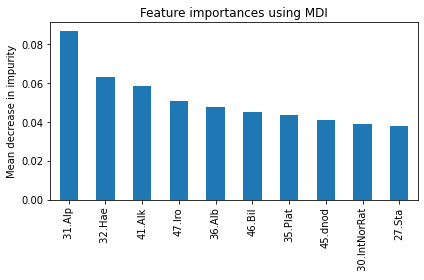

In [26]:
# fit the random forest 

feature_names = [new_df.columns[i] for i in range(X_train.shape[1])]
RF = RandomForestClassifier(random_state=0)
RF.fit(X_train, y_train)


# get the feature importance scores
importances = RF.feature_importances_



# graph the features 
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Feature importance based on feature permutation

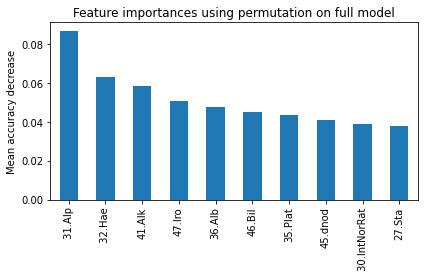

In [27]:
from sklearn.inspection import permutation_importance

RF = RandomForestClassifier(random_state=0)
RF.fit(X_train, y_train) 


result = permutation_importance(
    RF, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)



forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]


# time to graph
fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [28]:
# from these 2 analysis we have the top 3 features
# we'll use 3 features because we can plot top 2 features in 2D and top 3 features in 3D
# the top 3 features are Alkaline Phosphatase (U/L), Haemoglobin (g/dL), and Alpha-Fetoprotein (ng/dL)

# we'll now use the generative model using top 2 features first, and then all 3 features

# Part 3: A Generative Classifier


We can do this data analysis a different way. Instead of creating a fully predictive model with logistic regression (or say, a neural network) what if –– we do a non-parametric approach instead?

Let's take a look at the following equation, which states Bayes' Rule of Inference, but for two classification hypotheses we want to test:

$$\frac{P(H_1|Data)}{P(H_2|Data)} = \frac{f(Data|H_1)}{f(Data|H_2)}\frac{P(H_1)}{P(H_2)}$$

This equation basically says, that the odds of Hypothesis 1 being true after seeing the new data point, D, over the odds of Hypothesis 2 being true, is the ratio of how likely D fits hypothesis 1 over hypothesis 2 (symbolized by "f"), times the prior odds we believe that hypothesis 1 is right over hypothesis 2.

The part we call "f" is called the *likelihood* of the data fitting the hypothesis H1 or H2. It's usually difficult to calculate this, and we use the lowercase "f" instead of probability "P" because there are so many data points in our set, we consider the set *continuous* instead, and use "f". You can think of $f(x)$ as a *density* –– it gives us a map of how likely certain data points would be *given* that either hypothesis 1 or 2 is correct.

The difficult part is constructing $f(x)$. This would usually be part of "unsupervised learning", where the computer is traianed to find patterns in data without any labels. You might of heard, for example, K-Means – which clusters data into K different blobs based on the "centroid" of each cluster. 

Gaussian Mixture Modeling (GMM) is a general version of K-Means, and while it can be used for clustering, it has waaaay more power than that. Because GMM is a model, a *probabilistic model*, it basically tells us a whole bunch of info about how dense the data points are, and how probable is certain parts of the data from other parts. and one of the amazing things about GMM is that its a *generative model*, which means you can generate *new* samples of the data from your model pretty easily by just calling the .sample method in Sci-kit Learn. This would be pretty hard to do with K-means. 

In [29]:
forest_importances.index

Index([' 31.Alp', ' 32.Hae', '41.Alk', '47.Iro', '36.Alb', '46.Bil', '35.Plat',
       '45.dnod', ' 30.IntNorRat', '27.Sta'],
      dtype='object')

In [84]:
new_df[[' 31.Alp', ' 32.Hae', '41.Alk']]

,31.Alp,32.Hae,41.Alk
0,95.0,13.7,150.0
1,3.1,10.8,433.0
2,5.8,8.9,109.0
3,2440.0,13.4,174.0
4,49.0,14.3,109.0
...,...,...,...
160,3.9,15.4,109.0
161,4887.0,12.1,280.0
162,75.0,13.3,181.0
163,94964.0,15.6,170.0


In [30]:
# next we are going to separate the transformed dataset into either life (1) or death (0)
# class labels
# first we will do generative modeling with TOP 2 FEATURES, and then with all TOP 3 FEATURES

top_2_features = forest_importances.index[:2]
top_3_features = forest_importances.index[:3]

short_df_2feat = pd.DataFrame(X_train, columns=top_2_features)
short_df_2feat['Class'] = y_train

short_df_3feat = pd.DataFrame(X_train, columns=top_3_features)
short_df_3feat['Class'] = y_train

In [31]:
short_df_2feat.head() 

,31.Alp,32.Hae,Class
106,32.0,14.0,1
27,5.9,15.5,1
94,48.0,12.6,1
125,421500.0,14.3,0
90,123.0,10.1,0


In [32]:
short_df_3feat.head() 

,31.Alp,32.Hae,41.Alk,Class
106,32.0,14.0,174.0,1
27,5.9,15.5,111.0,1
94,48.0,12.6,91.0,1
125,421500.0,14.3,217.0,0
90,123.0,10.1,177.0,0


## Generative Model with Top 2 features 

In [33]:
short_df_2life = short_df_2feat[short_df_2feat['Class']==1]
short_df_2death = short_df_2feat[short_df_2feat['Class']==0]

short_df_2life.shape, short_df_2death.shape

((73, 3), (42, 3))

In [34]:
short_df_2life.head()

,31.Alp,32.Hae,Class
106,32.0,14.0,1
27,5.9,15.5,1
94,48.0,12.6,1
60,608.0,12.6,1
110,114.0,14.9,1


In [35]:
short_df_2life[' 31.Alp'].describe()

count       73.000000
mean      1055.427945
std       4516.002322
min          1.700000
25%          4.700000
50%          8.800000
75%         60.000000
max      33502.000000
Name:  31.Alp, dtype: float64

In [73]:
short_df_2life.columns

Index([' 31.Alp', ' 32.Hae', 'Class'], dtype='object')

Now, we are going to set up the Gaussian Mixture generative model. First we need to import it, and make an object instance of the class. And for the generative model, we are *not* going to touch the testing data; we'll just be dealing with the training set.

A question you might ask is: how many components do we need to use in the model? It's a great question! And the answer is often: we don't know beforehand. So instead of running 1 generative model, we are going to run 15 of them each model using from 1 componenent to N components. Once we do this, we can use a number called the *Akaike Information Criterion (AIC)* (don't ask me about it!) to determine how many clusters we should use. A good way to do this is called the "elbow method", where we look at the plotted graph of cluster number vs. AIC (it should look like a bent elbow where the bend is at the bottom), and we pick the cluster number closest to the bend.


In [37]:
X_train_2life = short_df_2life.iloc[:, :-1]
X_train_2death = short_df_2death.iloc[:, :-1]
X_train_2life.shape, X_train_2death.shape

((73, 2), (42, 2))

Now in order to apply density estimation as a predictive tool, ket's go back to the Bayesian inference hypothesis equation above. Because we balanced the class labels in our dataset, the quotient $\frac{P(H_1)}{P(H_2)}$ is 1 because the ratio of life-labels to death-labels is the same. So we only have to worry about the likelihood ratio. 

Dividing numbers in Python can give weird errors, so instead, we'll work with the *logarithm* of the likelihood ratio, written as:

$$log(\frac{P(Data|H_1)}{P(Data|H_2)})$$

which can be written as:

$$delta = log(P(Data|H_1) - log(P(Data|H_2))$$

The numerator we'll call *life_log_prob* and the denominator as *death_log_prob*.

Our key calculation is this: in the quotient of likelihoods, if the quotient is > 1, then the likelihood of the test data point under hypothesis 1 (class label=1) is higher than class label 0, so we classify it as "survival". Otherwise, it's classified as "death". When we take the logarithm of the likelihood ratio, what this classification rule translates to is that we classify the new data point as "survival" if the difference, $delta$ > 0, and "death" if $delta$ < 0.

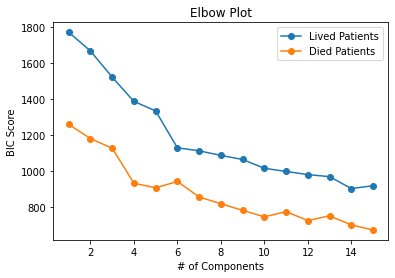

In [38]:
# we could also do kernel density estimation
# we're gonna be using bayesian search and cross-validation to find the BEST bandwidth value
# for each KDE estimate of the training data (based on class label)
# we'll be using K-fold cross validation


from sklearn.mixture import GaussianMixture

components = list(range(1, 16))
life_mixture_models = []
death_mixture_models = []



# patients who lived 

for i in tqdm(components, desc="Fitting life-data models"):
    life_mixture_models.append(GaussianMixture(i, random_state=0).fit(X_train_2life))
    
life_scores = [model.bic(X_train_2life) for model in life_mixture_models]


# now patients who died

for i in tqdm(components, desc="Fitting death-data models"):
    death_mixture_models.append(GaussianMixture(i, random_state=0).fit(X_train_2death))
    
death_scores = [model.bic(X_train_2death) for model in death_mixture_models]


fig = plt.figure()

# life plot 
plt.title('Elbow Plot')
plt.plot(components, life_scores, '-o', label='Lived Patients')
plt.plot(components, death_scores, '-o', label='Died Patients')
plt.xlabel('# of Components')
plt.ylabel('BIC Score')
plt.legend(loc='upper right')
plt.show()



In [39]:
# it seems like here, for modeling the data-generating process, the lived patients fit with 6 clusters,
# while for the died patients, they fit with 4 clusters at the elbow point


# now let us graph in 2D, a heatmap (perhaps with seaborn) for the lived-patients and died-patients data distribution
# / data generating process

life_model_2feature = GaussianMixture(n_components=6, random_state=0).fit(X_train_2life)
death_model_2feature = GaussianMixture(n_components=4, random_state=0).fit(X_train_2death)

In [40]:
# now, to use seaborn heatmap, we need to generate some data with the gaussian mixture first 

new_life_samples = life_model_2feature.sample(n_samples=100)
new_death_samples = death_model_2feature.sample(n_samples=100)

new_life_df = pd.DataFrame({'31.Alp': new_life_samples[0][:,0], '32.Hae': new_life_samples[0][:,1]})
new_death_df = pd.DataFrame({'31.Alp': new_death_samples[0][:,0], '32.Hae': new_death_samples[0][:,1]})


In [67]:
new_life_df


,31.Alp,32.Hae
0,21.676167,17.776978
1,-4.413940,11.933992
2,-20.372057,15.020083
3,5.251153,14.459027
4,13.487314,16.409858
...,...,...
95,243.205774,12.329051
96,-154.318020,11.471967
97,583.388483,11.979833
98,1456.185541,9.797363


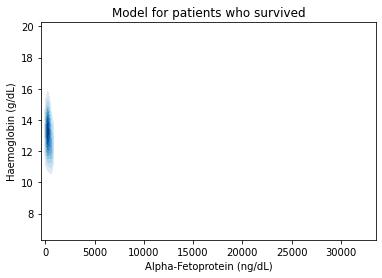

In [124]:
sns.kdeplot(new_life_df['31.Alp'], new_life_df['32.Hae'], shade=True, 
                 shade_lowest=False, color='blue', cmap='Blues')
plt.title('Model for patients who survived')
plt.xlabel('Alpha-Fetoprotein (ng/dL)')
plt.ylabel('Haemoglobin (g/dL)')

plt.show()

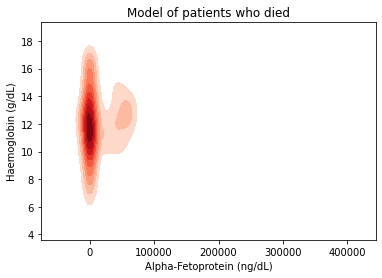

In [125]:
sns.kdeplot(new_death_df['31.Alp'], new_death_df['32.Hae'], shade=True, 
                 shade_lowest=False, color='red', cmap='Reds')

plt.title('Model of patients who died')
plt.xlabel('Alpha-Fetoprotein (ng/dL)')
plt.ylabel('Haemoglobin (g/dL)')
            
plt.show()

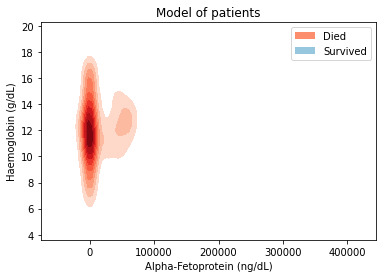

In [129]:
import matplotlib.patches as  mpatches



sns.kdeplot(new_life_df['31.Alp'], new_life_df['32.Hae'], shade=True, 
                 shade_lowest=False, color='blue', cmap='Blues')

sns.kdeplot(new_death_df['31.Alp'], new_death_df['32.Hae'], shade=True, 
                 shade_lowest=False, color='red', cmap='Reds')




handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Died"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Survived")]


plt.title('Model of patients')
plt.xlabel('Alpha-Fetoprotein (ng/dL)')
plt.ylabel('Haemoglobin (g/dL)')
plt.legend(handles=handles)
plt.show()





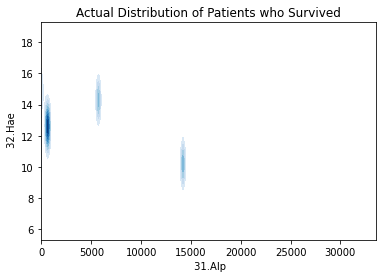

In [126]:
sns.kdeplot(short_df_2life[' 31.Alp'], short_df_2life[' 32.Hae'],
           shade=True, shade_lowest=False, color='blue', cmap='Blues')

plt.title("Actual Distribution of Patients who Survived")
plt.show()

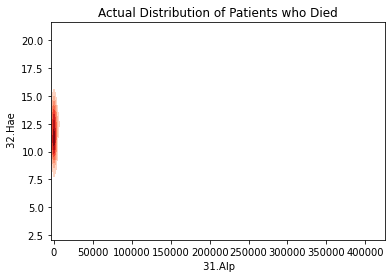

In [127]:
sns.kdeplot(short_df_2death[' 31.Alp'], short_df_2death[' 32.Hae'],
           shade=True, shade_lowest=False, color='red', cmap='Reds')

plt.title("Actual Distribution of Patients who Died")
plt.show()

In [91]:
# now let us use our models to predict on test data!

X_test.shape
short_X_test_2feat = pd.DataFrame(X_test, columns=top_2_features)
short_X_test_3feat = pd.DataFrame(X_test, columns=top_3_features)

short_X_test_2feat.shape, short_X_test_3feat.shape

((50, 2), (50, 3))

In [92]:
short_X_test_2feat.head()

,31.Alp,32.Hae
45,2.8,16.6
51,41470.0,12.6
108,173.0,11.3
7,9860.0,10.8
73,20.0,13.0


In [199]:
# we'll get the life-logliklihood MINUS the death-loglikelihood for the short X_test data (using score_samples)
# on all 50 samples from X_test. Then we will exponential the log difference to get the Bayes factor
# finally we multiply the prior odds by the bayes factor to get posterior odds, to make a decision

# bcause 1 = predicting Patient is healthy, and 0 = predicting patient has cancer, we do NOT wanna lie to the patient
# and predict 1 for them, when it's really 0 (cancer). So we wanna penalize false negatives

# lets say false negatives are 5 times as worse as false positives in our opinion. Then, if we wanna compare the 
# posterior-odds ratio of p(Y=1|Data)/p(Y=0|Data), we should predict Y=1 ONLY IF this ratio > 5. or log(posterior) > log(5).

log_Bayes_odds = life_model_2feature.score_samples(short_X_test_2feat) - death_model_2feature.score_samples(short_X_test_2feat)

log_prior_odds = np.log(short_df_2life.shape[0]/short_df_2death.shape[0])

log_posterior_odds = log_Bayes_odds + ( log_prior_odds*np.ones(short_X_test_2feat.shape[0]) )

decisions = []

threshold = 20

for odds in log_posterior_odds:
    if odds > np.log(threshold):
        decisions.append(1)
    #elif O >= 1.0 and O < 3.0:
     #   decisions.append('Uncertain')
    else: 
        decisions.append(0)

In [200]:
np.log(threshold)

2.995732273553991

In [201]:
log_posterior_odds

array([ 3.48529941e+00, -6.78393567e+03, -1.97142242e+00, -3.31206763e+02,
        2.80994699e+00,  2.61120829e+00, -1.49426569e+00,  5.83365744e-01,
        2.99045079e+00, -3.64045535e+04,  3.22026225e+00,  3.11878849e+00,
        7.21656072e-01,  4.19994865e+00,  4.06208243e+00,  2.95120847e+00,
        3.29158937e+00,  3.42581703e+00, -8.04746704e+00,  5.91187470e+00,
        4.15531448e+00, -3.58919383e+00,  3.46565358e+00,  3.11086789e+00,
        4.40893213e+00,  3.79412127e-01,  2.80472854e+00,  1.09713167e+00,
        1.60526373e+00, -1.32238656e+07,  2.20359376e+00, -4.02527431e+00,
        3.66568128e+00,  2.91196606e+00, -1.02331008e+02,  3.28084945e+00,
        2.89295629e+00,  2.14079869e+00, -3.29694208e-01, -1.06417991e+01,
       -2.63846858e+00,  2.85788364e+00, -2.18353835e+00,  3.13669549e+00,
       -1.80587529e+00, -1.93719994e+00, -1.52502648e+00, -1.57916667e+01,
        3.42091739e+00,  2.86026100e+00])

$(Model Odds)*(Prior Odds) = \frac{p(Y=1|Data)}{p(Y=0|Data)} = \frac{p(Patient Survived)}{p(Patient Died)}≥ 5$

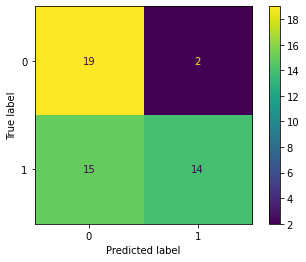

In [202]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix 

cmatrix = confusion_matrix(np.asarray(y_test), np.asarray(decisions))

cmatrix_display = ConfusionMatrixDisplay(cmatrix).plot()